In [1]:
import sys

sys.path.append('../../MembraneQuant')
from membranequant import *
import pandas as pd

%matplotlib notebook

Attempt to calibrate based on assumption that dosage should be the same in wild type and par-3 mutant conditions

However, this didn't work

Previous optogenetics experiment puts c parameter at 3.5 with svr = 0.174

### Import data

In [2]:
cytbg = np.loadtxt('../GCN4 PAR-2/cyt_profile.txt')
membg = np.loadtxt('../PAR-2 RING MUTANTS/mem_profile.txt')

In [3]:
base_paths_pol = ['/Users/blandt/Desktop/Rundowns/Experiment/211118_nwg325_wt_tom4,15,60', 
             '/Users/blandt/Desktop/RING lines/Experiment/211106_nwg325_tom4,15,60', 
             '/Users/blandt/Desktop/RING lines/Experiment/211112_nwg325_tom4,15,60']
base_paths_uni = ['/Users/blandt/Desktop/Rundowns/Experiment/211113_nwg201_wt_tom4,15,60',
            '/Users/blandt/Desktop/Rundowns/Experiment/211117_nwg201_wt_tom4,15,60']

paths_pol = direcslist(base_paths_pol)
paths_uni = direcslist(base_paths_uni)
conditions = ['pol'] * len(paths_pol) + ['uni'] * len(paths_uni)

In [4]:
imgs_pol = [load_image(p + '/af_corrected_3channel_flat.tif') for p in paths_pol]
imgs_uni = [load_image(p + '/af_corrected_3channel_flat.tif') for p in paths_uni]

rois_pol = [np.loadtxt(p + '/ROI_fit.txt') for p in paths_pol]
rois_uni = [np.loadtxt(p + '/ROI_fit.txt') for p in paths_uni]

### Run quantification

In [5]:
iq = ImageQuant(img=imgs_pol + imgs_uni, cytbg=cytbg, membg=membg, roi=rois_pol + rois_uni, uni_cyt=True, 
                descent_steps=200, iterations=1, rol_ave=5, lr=0.02)

In [6]:
iq.run()

100%|██████████| 200/200 [00:40<00:00,  4.91it/s]


Time elapsed: 41.54 seconds 


<IPython.core.display.Javascript object>


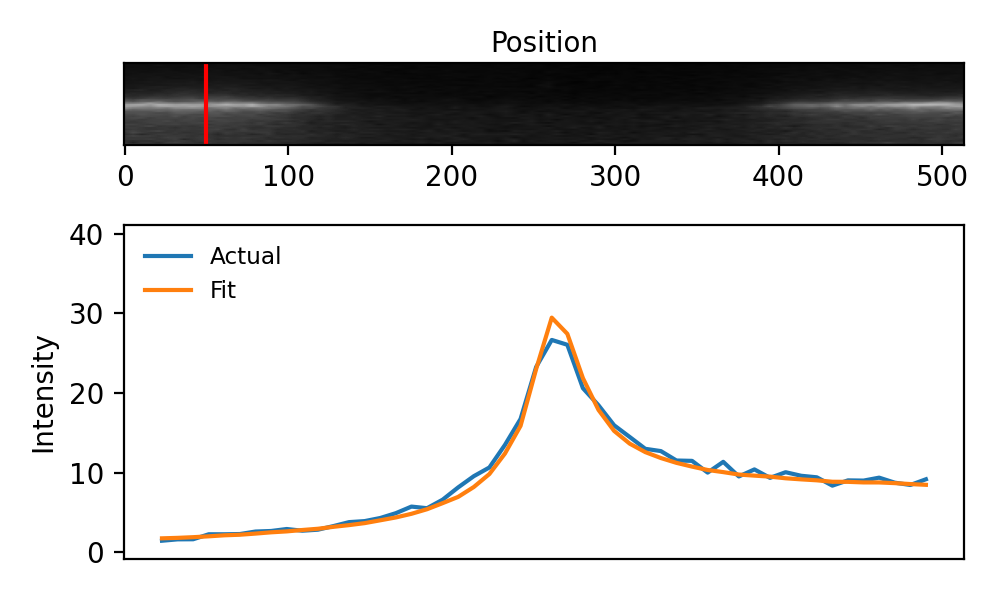

interactive(children=(IntSlider(value=0, description='Frame', max=16), FloatSlider(value=0.1, description='Pos…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [7]:
iq.plot_fits(jupyter=True)

### Calibration

In [8]:
res = iq.compile_res()
res

,Frame,Position,Membrane signal,Cytoplasmic signal
0,0,0,29.643569,3.820299
1,0,1,28.585405,3.820299
2,0,2,29.614986,3.820299
3,0,3,29.372587,3.820299
4,0,4,31.058260,3.820299
...,...,...,...,...
95,16,95,14.958519,3.545563
96,16,96,15.757010,3.545563
97,16,97,18.363782,3.545563
98,16,98,16.648935,3.545563


In [9]:
mems = [res[res.Frame == i]['Membrane signal'].to_numpy() for i in range(len(iq.roi))]
cyts = [res[res.Frame == i]['Cytoplasmic signal'].to_numpy() for i in range(len(iq.roi))]
norm_rois = [norm_roi(r) for r in iq.roi]

mems_means = [np.average(interp_1d_array(m, nr.shape[0], 'linear'), 
                         weights=abs(nr[:, 1])) for m, nr in zip(mems, norm_rois)]
cyts_means = [np.average(interp_1d_array(c, nr.shape[0], 'linear'), 
                         weights=abs(nr[:, 1]) ** 2) for c, nr in zip(cyts, norm_rois)]

<IPython.core.display.Javascript object>


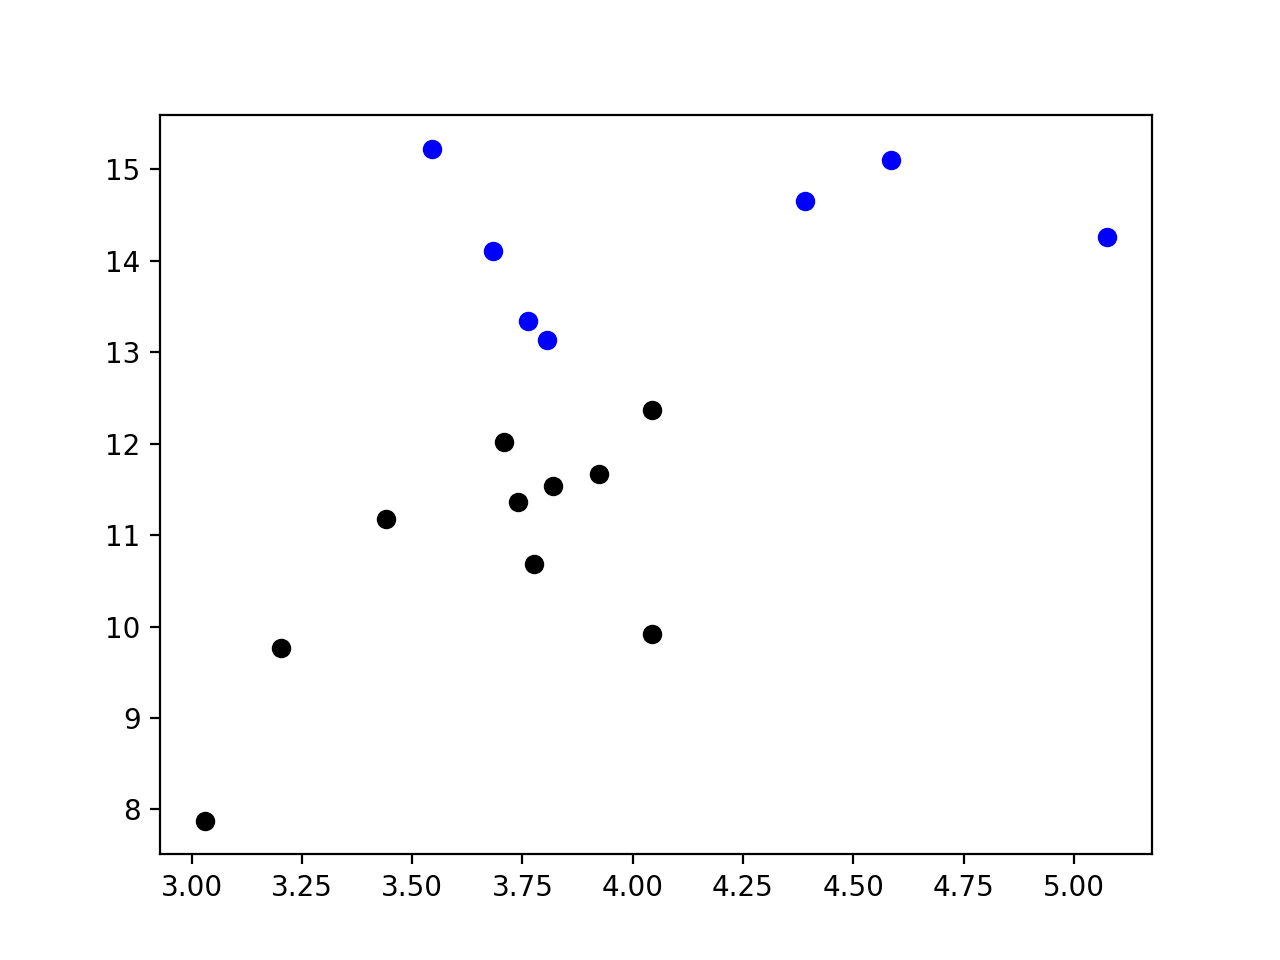

In [10]:
fig, ax = plt.subplots()
[ax.scatter(cyts_means[i], mems_means[i], c='k') for i, c in enumerate(conditions) if c == 'pol'];
[ax.scatter(cyts_means[i], mems_means[i], c='b') for i, c in enumerate(conditions) if c == 'uni'];

No strong separation between the groups, so this won't work. Need to use the optogenetics method instead

Also strange that uni seems to have both higher average cytoplasm and higher average membrane, indicating that there's more protein